# Project D10: KAGGLE - Movie Ratings

Authors:
- Kevin Kliimask
- Jens Jäger
- Taavi Eistre

<font color='red'>TODO: Write introductive text</font>

## Importing the data

We will start off with importing all the necessary packages and the data.
After looking at the data manually, we saw that 6 rows were 'broken' so to say with a lot of misaligned columns, so we decided to skip them.
We will be using the selected columns from the report.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import math
import ast
%matplotlib inline

data = pd.read_csv('movies_metadata.csv', skiprows=[19730, 19731, 29503, 29504, 35587, 35588],
                   usecols=['original_title', 'original_language', 'genres', 'production_companies',
                            'production_countries', 'runtime', 'revenue', 'release_date', 'vote_average'])

## Preprocessing the data

First off we'll remove all the duplicate rows (movies).

In [2]:
print(f'The number of movies before removing the duplicates: {len(data)}')
data = data.drop_duplicates(ignore_index=True)

print(f'The number of movies after removing the duplicates: {len(data)}')

data.head()

The number of movies before removing the duplicates: 45460
The number of movies after removing the duplicates: 45430


,genres,original_language,original_title,production_companies,production_countries,release_date,revenue,runtime,vote_average
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,81.0,7.7
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249,104.0,6.9
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0,101.0,6.5
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156,127.0,6.1
4,"[{'id': 35, 'name': 'Comedy'}]",en,Father of the Bride Part II,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911,106.0,5.7


Next off we will be converting the **JSON** formats of columns **'genres'**, **'production_companies'** and **'production_countries'** to a list format using the help of `ast.literal_eval()`,
which helps to parse the columns' objects into the desired type.

In [3]:
data['genres'] = data['genres'].apply(lambda genres_list: [genres['name'] for genres in ast.literal_eval(genres_list)])

data['production_companies'] = data['production_companies'].apply(lambda companies_list: [companies['name'] for companies in ast.literal_eval(companies_list)])

data['production_countries'] = data['production_countries'].apply(lambda countries_list: [countries['name'] for countries in ast.literal_eval(countries_list)])

data.head()

,genres,original_language,original_title,production_companies,production_countries,release_date,revenue,runtime,vote_average
0,"[Animation, Comedy, Family]",en,Toy Story,[Pixar Animation Studios],[United States of America],1995-10-30,373554033,81.0,7.7
1,"[Adventure, Fantasy, Family]",en,Jumanji,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249,104.0,6.9
2,"[Romance, Comedy]",en,Grumpier Old Men,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0,101.0,6.5
3,"[Comedy, Drama, Romance]",en,Waiting to Exhale,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156,127.0,6.1
4,[Comedy],en,Father of the Bride Part II,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911,106.0,5.7


Next we will remove all the movies that have:
- No genres
- No production countries
- No production companies
- 0 runtime
- 0 vote_average
- NaN values

In [4]:
print(f'The number of movies before removing all of the mentioned movies above: {len(data)}')

data = data.dropna()
data = data[(data.runtime > 0) & (data.vote_average > 0) & (data.genres.str.len() > 0) & (data.production_companies.str.len() > 0) & (data.production_countries.str.len() > 0)]
data = data.reset_index(drop=True)

print(f'The number of movies after removing all of the mentioned movies above: {len(data)}')

The number of movies before removing all of the mentioned movies above: 45430
The number of movies after removing all of the mentioned movies above: 31061


Finding the **total number** and **frequency** of genres, companies and countries.

In [5]:
genres_dict = {}
companies_dict = {}
countries_dict = {}

for index, row in data.iterrows():
    for genre in row['genres']:
        genres_dict[genre] = genres_dict.get(genre, 0) + 1

    for company in row['production_companies']:
        companies_dict[company] = companies_dict.get(company, 0) + 1

    for country in row['production_countries']:
        countries_dict[country] = countries_dict.get(country, 0) + 1

In [6]:
print(f'The number of genres: {len(genres_dict)}')
print(f'The number of production companies: {len(companies_dict)}')
print(f'The number of production countries: {len(countries_dict)}')

The number of genres: 20
The number of production companies: 22390
The number of production countries: 151


After seeing that there are **too many** production companies, we decided not to use them on the model.

## Exploring our data

Now that we have cleaned the data, let's have a look at what interesting we can find from what remains.

In [7]:
data.head()

,genres,original_language,original_title,production_companies,production_countries,release_date,revenue,runtime,vote_average
0,"[Animation, Comedy, Family]",en,Toy Story,[Pixar Animation Studios],[United States of America],1995-10-30,373554033,81.0,7.7
1,"[Adventure, Fantasy, Family]",en,Jumanji,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249,104.0,6.9
2,"[Romance, Comedy]",en,Grumpier Old Men,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0,101.0,6.5
3,"[Comedy, Drama, Romance]",en,Waiting to Exhale,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156,127.0,6.1
4,[Comedy],en,Father of the Bride Part II,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911,106.0,5.7


Firstly, we'll look at the top 10 highest rated movies.

In [8]:
print(f'The number of movies with a rating of 10: {len(data[data.vote_average == 10])}')
data.sort_values(by=['vote_average'], ascending=False).head(10)[['original_title', 'vote_average']]

The number of movies with a rating of 10: 79


,original_title,vote_average
18376,Tall Story,10.0
643,Carmen Miranda: Bananas Is My Business,10.0
16946,Criminal Justice,10.0
9637,Joe Cocker - Mad Dogs & Englishmen,10.0
16940,Growing Pains,10.0
23820,Mariposa,10.0
21018,Vessel of Wrath,10.0
9886,Something in the Wind,10.0
19811,George Lopez: America's Mexican,10.0
22038,Crooks and Coronets,10.0


Next, we will see the **frequency** histogram of the top 25 original languages of movies.

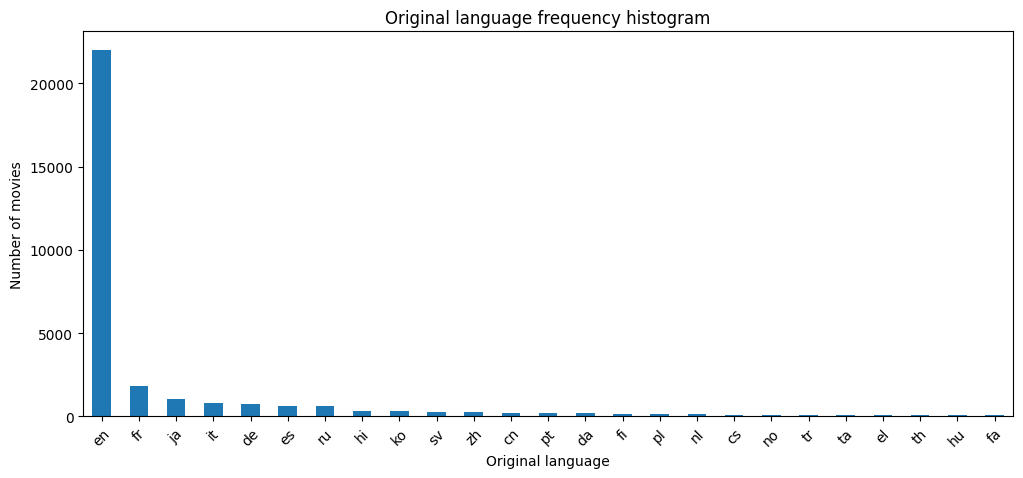

In [9]:
language_freq = data['original_language'].value_counts()[:25]
language_freq.plot(kind='bar', figsize=(12, 5), rot=45, xlabel='Original language', ylabel='Number of movies', title='Original language frequency histogram')
plt.show()

Next up, runtime **frequency** histogram.

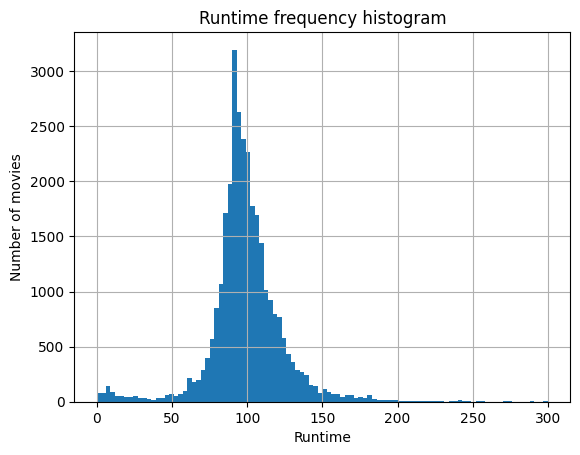

In [10]:
data['runtime'].hist(bins=100, range=[0, 300])
plt.title('Runtime frequency histogram')
plt.xlabel('Runtime')
plt.ylabel('Number of movies')

plt.show()

The vote average (rating) **frequency** histogram.

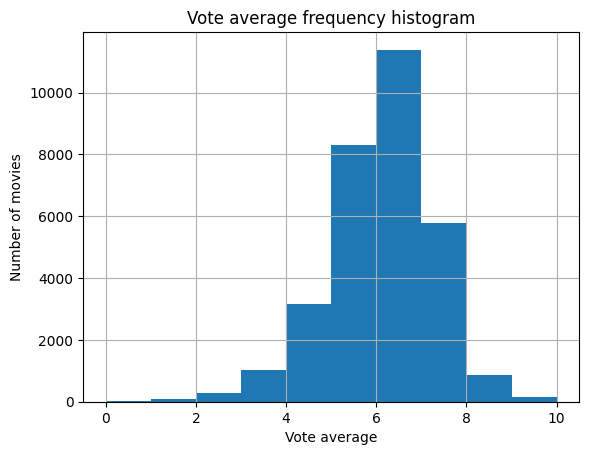

In [11]:
data['vote_average'].hist(bins=10, range=[0, 10])
plt.title('Vote average frequency histogram')
plt.xlabel('Vote average')
plt.ylabel('Number of movies')

plt.show()

Now, let's see the **relative frequency** histogram of genres.

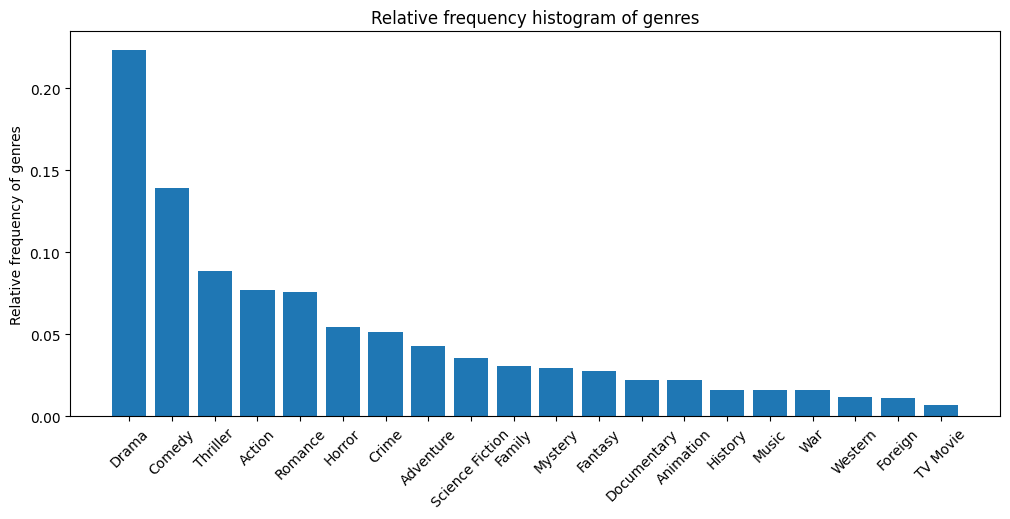

In [12]:
genres_dict = dict(sorted(genres_dict.items(), key=lambda x: x[1], reverse=True))
total_number = 0
for freq in genres_dict.values():
    total_number += freq

plt.figure(figsize=(12, 5))
plt.bar(range(len(genres_dict)), [freq / total_number for freq in genres_dict.values()], align='center')
plt.xticks(range(len(genres_dict)), list(genres_dict.keys()), rotation=45)
plt.ylabel('Relative frequency of genres')
plt.title('Relative frequency histogram of genres')

plt.show()

The **relative frequency** histogram of the top 25 production companies.

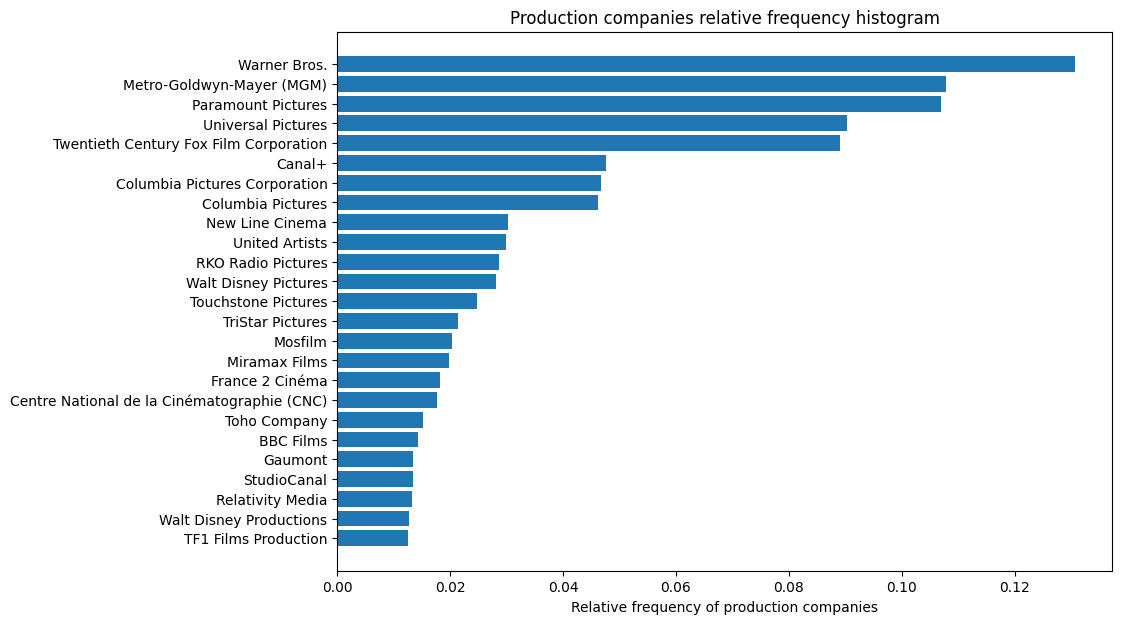

In [13]:
companies_dict = dict(sorted(companies_dict.items(), key=lambda x: x[1], reverse=True)[:25])
total_number = 0
for freq in companies_dict.values():
    total_number += freq

plt.figure(figsize=(10, 7))
plt.barh(list(companies_dict.keys()), [freq / total_number for freq in companies_dict.values()], align='center', orientation='horizontal')
plt.gca().invert_yaxis()
plt.xlabel('Relative frequency of production companies')
plt.title('Production companies relative frequency histogram')

plt.show()

And finally, the **relative frequency** histogram of the top 25 production countries.

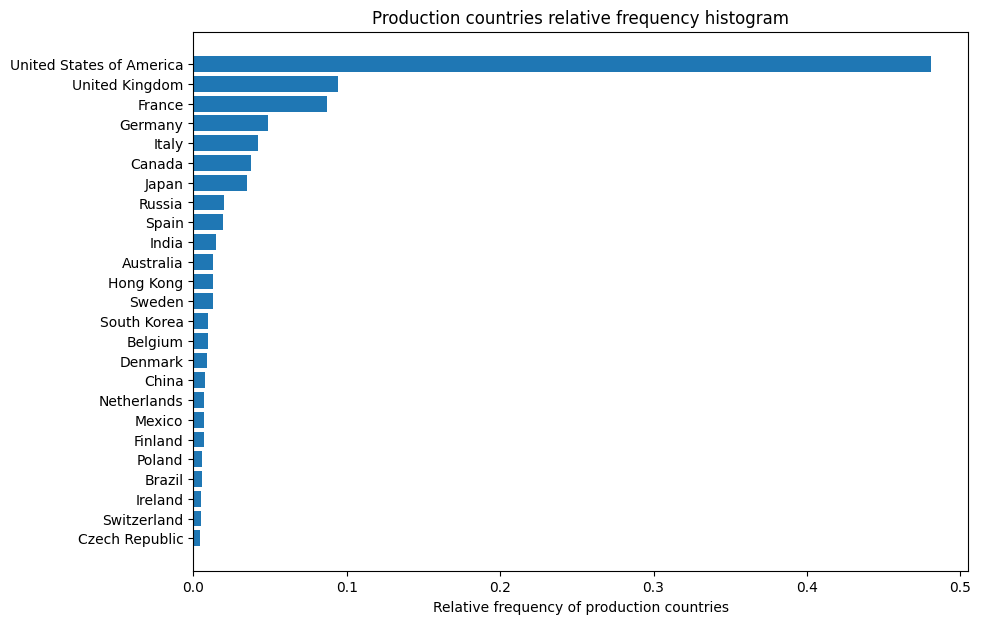

In [14]:
countries_dict = dict(sorted(countries_dict.items(), key=lambda x: x[1], reverse=True))
total_number = 0
for freq in list(countries_dict.values())[:25]:
    total_number += freq

plt.figure(figsize=(10, 7))
plt.barh(list(countries_dict.keys())[:25], [freq / total_number for freq in list(countries_dict.values())[:25]], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Relative frequency of production countries')
plt.title('Production countries relative frequency histogram')

plt.show()

The top 15 mean yearly revenues.

<AxesSubplot: title={'center': 'Top 15 mean yearly revenue'}, xlabel='Release year', ylabel='Yearly mean revenue (mil)'>

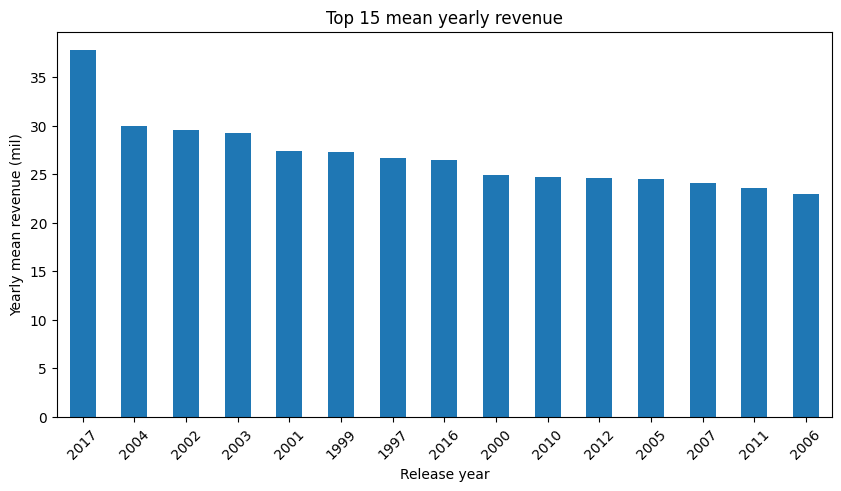

In [15]:
data['release_date'] = data['release_date'].apply(lambda date: str(date)[:4])

yearly_revenues = data.groupby('release_date')['revenue'].mean().sort_values(ascending=False)[:15]
yearly_revenues = yearly_revenues.apply(lambda x: round(x / 1_000_000, 2))

yearly_revenues.plot(kind='bar', figsize=(10, 5), rot=45, title='Top 15 mean yearly revenue', xlabel='Release year', ylabel='Yearly mean revenue (mil)')

## Starting with the model
## Preparing data

We will drop 'original_title', 'production_companies', 'release_date' and 'revenue', as these are not going to be used in the model.

In [16]:
data.head()

,genres,original_language,original_title,production_companies,production_countries,release_date,revenue,runtime,vote_average
0,"[Animation, Comedy, Family]",en,Toy Story,[Pixar Animation Studios],[United States of America],1995,373554033,81.0,7.7
1,"[Adventure, Fantasy, Family]",en,Jumanji,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995,262797249,104.0,6.9
2,"[Romance, Comedy]",en,Grumpier Old Men,"[Warner Bros., Lancaster Gate]",[United States of America],1995,0,101.0,6.5
3,"[Comedy, Drama, Romance]",en,Waiting to Exhale,[Twentieth Century Fox Film Corporation],[United States of America],1995,81452156,127.0,6.1
4,[Comedy],en,Father of the Bride Part II,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995,76578911,106.0,5.7


In [17]:
data = data.drop(columns=['original_title', 'production_companies', 'release_date', 'revenue'])

data.head()

,genres,original_language,production_countries,runtime,vote_average
0,"[Animation, Comedy, Family]",en,[United States of America],81.0,7.7
1,"[Adventure, Fantasy, Family]",en,[United States of America],104.0,6.9
2,"[Romance, Comedy]",en,[United States of America],101.0,6.5
3,"[Comedy, Drama, Romance]",en,[United States of America],127.0,6.1
4,[Comedy],en,[United States of America],106.0,5.7


Then we will use pd.get_dummies to one-hot-encode 'original_language' column.

In [18]:
data = pd.get_dummies(data, columns=['original_language'])
data.head()

,genres,production_countries,runtime,vote_average,original_language_ab,original_language_af,original_language_am,original_language_ar,original_language_ay,original_language_bg,...,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu
0,"[Animation, Comedy, Family]",[United States of America],81.0,7.7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[Adventure, Fantasy, Family]",[United States of America],104.0,6.9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[Romance, Comedy]",[United States of America],101.0,6.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[Comedy, Drama, Romance]",[United States of America],127.0,6.1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[Comedy],[United States of America],106.0,5.7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we will be using MultiLabelBinarizer() from sklearn to one-hot-encode 'genres' and 'production_countries' columns.

In [19]:
genres_columns = [genre for genre in genres_dict.keys()]

countries_columns = [country for country in countries_dict.keys()]

In [20]:
mlb = MultiLabelBinarizer()

genres_list = pd.DataFrame(mlb.fit_transform(data['genres']), columns=genres_columns)

countries_list = pd.DataFrame(mlb.fit_transform(data['production_countries']), columns=countries_columns)

data = pd.concat([data.drop(columns=['genres', 'production_countries']), genres_list, countries_list], axis=1)

## Splitting the data

Splitting the data for training and testing. For this we will be using train_test_split from sklearn.

In [21]:
X = data.drop(columns=['vote_average'])
y = data['vote_average']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

print('Features data shape:')
print(X_train.shape)
print('Values data shape:')
print(y_train.shape)

Features data shape:
(23295, 255)
Values data shape:
(23295,)


We will be trying to train the model on two different training data. The first one will be the full training dataset and the second one will be a more balanced one, where movie ratings (vote averages) try to be in equal number (same number of 2's as there are 4's for example).

In [23]:
train_new = pd.concat([X_train, y_train], axis=1)

train_0_4 = train_new[train_new.vote_average < 5]
train_5_6 = train_new[(train_new.vote_average >= 5) & (train_new.vote_average < 7)]
train_7_10 = train_new[train_new.vote_average >= 7]

print(f'Length of movies with 0-4: {len(train_0_4)}')
print(f'Length of movies with 5-6: {len(train_5_6)}')
print(f'Length of movies with 7-10: {len(train_7_10)}')

Length of movies with 0-4: 3389
Length of movies with 5-6: 14811
Length of movies with 7-10: 5095


In [24]:
train_5_6 = train_5_6.sample(n=3389, random_state=0)
train_7_10 = train_7_10.sample(n=3389, random_state=0)

train_new = pd.concat([train_0_4, train_5_6, train_7_10]).sort_index()

X_train_new = train_new.drop(columns=['vote_average'])
y_train_new = train_new['vote_average']

In [25]:
print(f'Length of original training data: {len(X_train)}')
print(f'Length of more balanced training data: {len(X_train_new)}')

Length of original training data: 23295
Length of more balanced training data: 10167


Defining our way of determining the accuracy of the models.
For this we will be using root mean squared error.

In [26]:
def MSE(y_target, y_pred):
    sum = 0
    for i in range(len(y_target)):
        sum += (y_target[i] - y_pred[i]) ** 2
    return sum / len(y_target)

def RMSE(y_target, y_pred):
    return math.sqrt(MSE(y_target, y_pred))

## Training the models

We will be trying Linear Regression, Ridge Regression and Lasso Regression for this dataset.

In [27]:
linear_1 = LinearRegression()
linear_2 = LinearRegression()

ridge_1 = Ridge()
ridge_2 = Ridge()

lasso_1 = Lasso()
lasso_2 = Lasso()

Fitting the models.

In [28]:
linear_1 = linear_1.fit(X_train, y_train)
linear_2 = linear_2.fit(X_train_new, y_train_new)

ridge_1 = ridge_1.fit(X_train, y_train)
ridge_2 = ridge_2.fit(X_train_new, y_train_new)

lasso_1 = lasso_1.fit(X_train, y_train)
lasso_2 = lasso_2.fit(X_train_new, y_train_new)

## Testing the models

Having the new models predict on the testing data.

In [29]:
linear_1_pred = linear_1.predict(X_test)
linear_2_pred = linear_2.predict(X_test)

ridge_1_pred = ridge_1.predict(X_test)
ridge_2_pred = ridge_2.predict(X_test)

lasso_1_pred = lasso_1.predict(X_test)
lasso_2_pred = lasso_2.predict(X_test)

Finding the accuracy of our new models.

In [30]:
print(f'RMSE for LR (unbalanced) - {RMSE(y_test.to_numpy(), linear_1_pred)}')
print(f'RMSE for LR (more balanced) - {RMSE(y_test.to_numpy(), linear_2_pred)}\n')

print(f'RMSE for Ridge (unbalanced) - {RMSE(y_test.to_numpy(), ridge_1_pred)}')
print(f'RMSE for Ridge (more balanced) - {RMSE(y_test.to_numpy(), ridge_2_pred)}\n')

print(f'RMSE for Lasso (unbalanced) - {RMSE(y_test.to_numpy(), lasso_1_pred)}')
print(f'RMSE for Lasso (more balanced) - {RMSE(y_test.to_numpy(), lasso_2_pred)}\n')

RMSE for LR (unbalanced) - 149041414.69989163
RMSE for LR (more balanced) - 627385811.0534695

RMSE for Ridge (unbalanced) - 1.0980506539834747
RMSE for Ridge (more balanced) - 1.140455651749113

RMSE for Lasso (unbalanced) - 1.1765992323917753
RMSE for Lasso (more balanced) - 1.1939695490226225



As we can see, Ridge Regression performed the best on our test set with a root mean squared error of about 1.09.